In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [49]:
print("=" * 60)
print("Part 1: Setup and Data Preparation")
print("=" * 60)

# Create dataset
X, y = make_circles(n_samples=1000, noise=0.03, factor=0.5, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).unsqueeze(1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).unsqueeze(1)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

print(f"Training size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Part 1: Setup and Data Preparation
Using device: cpu
Training size: 800
Test size: 200


In [50]:
print("\n" + "=" * 60)
print("Part 2: Linear Model (CircleModelV0)")
print("=" * 60)

class CircleModelV0(nn.Module):
    """Linear model - no activation"""
    def __init__(self):
        super(CircleModelV0, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, 8),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)

model_v0 = CircleModelV0().to(device)
print("CircleModelV0 (Linear):")
print(model_v0)



Part 2: Linear Model (CircleModelV0)
CircleModelV0 (Linear):
CircleModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [51]:
print("\n" + "=" * 60)
print("Part 3: Non-Linear Model (CircleModelV1)")
print("=" * 60)

class CircleModelV1(nn.Module):
    """Non-linear model with ReLU activation"""
    def __init__(self):
        super(CircleModelV1, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),  # Add non-linearity!
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)

model_v1 = CircleModelV1().to(device)
print("CircleModelV1 (Non-linear):")
print(model_v1)



Part 3: Non-Linear Model (CircleModelV1)
CircleModelV1 (Non-linear):
CircleModelV1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [52]:
print("\n" + "=" * 60)
print("Part 4: Train Both Models")
print("=" * 60)

def train_model(model, model_name, epochs=100):
    """Train a model and return metrics"""
    print(f"\nTraining {model_name}...")

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        y_logits = model(X_train)
        loss = criterion(y_logits, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            test_loss = criterion(test_logits, y_test)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

    # Calculate final accuracy
    model.eval()
    with torch.inference_mode():
        test_probs = torch.sigmoid(test_logits)
        test_preds = (test_probs > 0.5).long()
        accuracy = (test_preds == y_test).float().mean()

    print(f"{model_name} - Test Accuracy: {accuracy.item()*100:.2f}%")

    return train_losses, test_losses, accuracy.item()

# Train both models
losses_v0_train, losses_v0_test, acc_v0 = train_model(model_v0, "CircleModelV0 (Linear)")
losses_v1_train, losses_v1_test, acc_v1 = train_model(model_v1, "CircleModelV1 (Non-linear)")



Part 4: Train Both Models

Training CircleModelV0 (Linear)...
CircleModelV0 (Linear) - Test Accuracy: 46.50%

Training CircleModelV1 (Non-linear)...
CircleModelV1 (Non-linear) - Test Accuracy: 93.50%



Part 5: Compare Training Curves


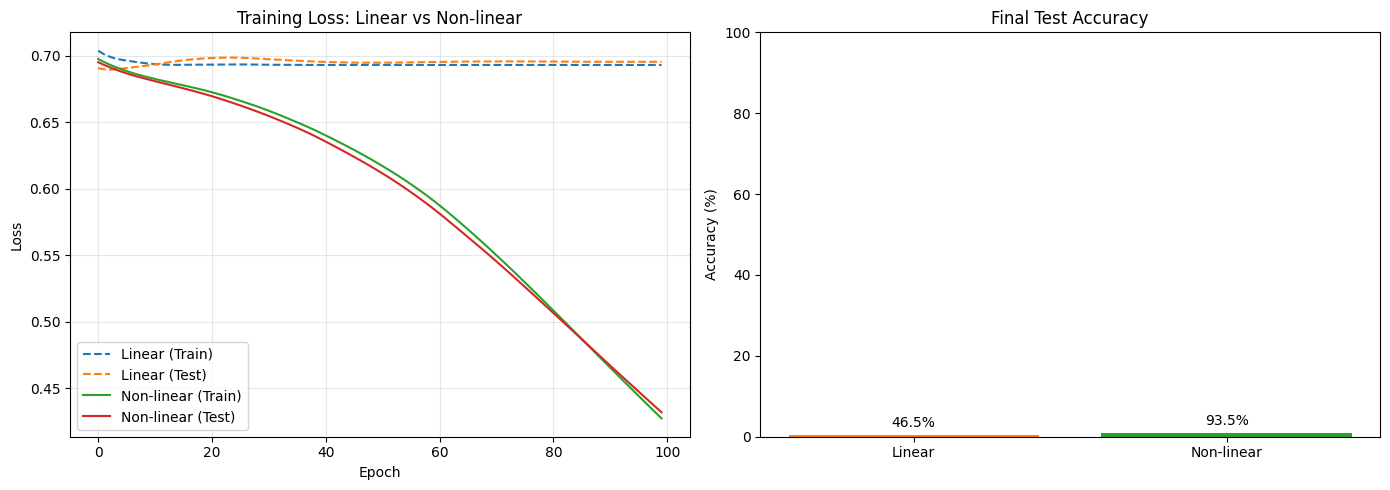


Comparison:
Linear Model Accuracy:     46.50%
Non-linear Model Accuracy: 93.50%


In [53]:
print("\n" + "=" * 60)
print("Part 5: Compare Training Curves")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss comparison
axes[0].plot(losses_v0_train, label='Linear (Train)', linestyle='--')
axes[0].plot(losses_v0_test, label='Linear (Test)', linestyle='--')
axes[0].plot(losses_v1_train, label='Non-linear (Train)')
axes[0].plot(losses_v1_test, label='Non-linear (Test)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss: Linear vs Non-linear')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].bar(['Linear', 'Non-linear'], [acc_v0, acc_v1], color=['#ff7f0e', '#2ca02c'])
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Final Test Accuracy')
axes[1].set_ylim(0, 100)
for i, v in enumerate([acc_v0, acc_v1]):
    axes[1].text(i, v + 2, f'{v*100:.1f}%', ha='center')

plt.tight_layout()
plt.show()

print("\nComparison:")
print(f"Linear Model Accuracy:     {acc_v0*100:.2f}%")
print(f"Non-linear Model Accuracy: {acc_v1*100:.2f}%")


Part 6: Decision Boundary Visualization


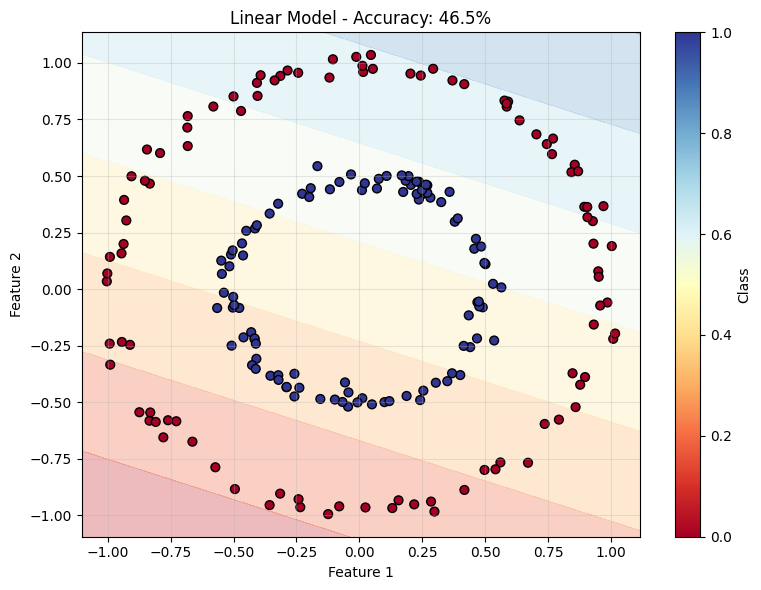

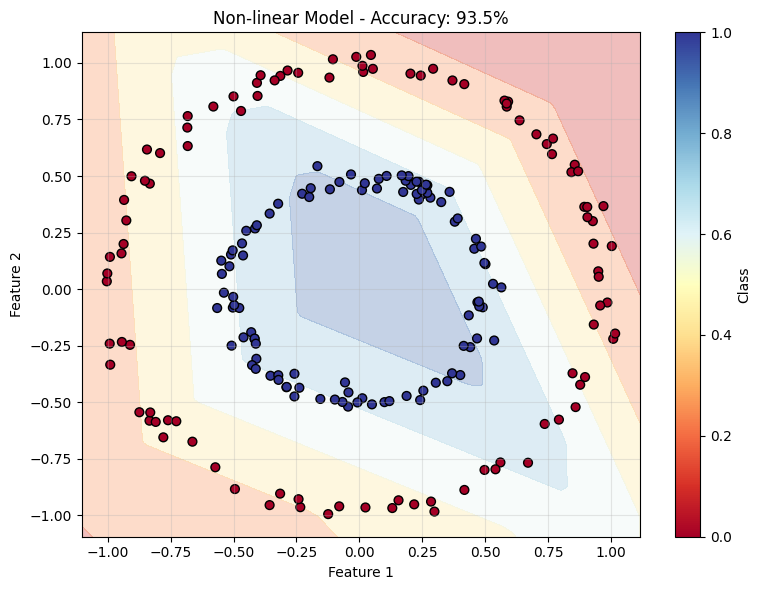

In [54]:
print("\n" + "=" * 60)
print("Part 6: Decision Boundary Visualization")
print("=" * 60)

def plot_decision_boundary(model, X, y, title):
    """Plot decision boundary for a model"""
    model.eval()

    # Create meshgrid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )

    # Make predictions on meshgrid
    mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    with torch.inference_mode():
        Z = torch.sigmoid(model(mesh)).reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z.cpu().numpy(), alpha=0.3, cmap='RdYlBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='RdYlBu', edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.colorbar(label='Class')
    plt.tight_layout()
    plt.show()

# Plot decision boundaries
X_test_np = X_test.cpu().numpy()
y_test_np = y_test.cpu().numpy().squeeze()

plot_decision_boundary(model_v0, X_test_np, y_test_np,
                      f'Linear Model - Accuracy: {acc_v0*100:.1f}%')
plot_decision_boundary(model_v1, X_test_np, y_test_np,
                      f'Non-linear Model - Accuracy: {acc_v1*100:.1f}%')


In [55]:
print("\n" + "=" * 60)
print("Part 7: Why Non-Linearity Matters")
print("=" * 60)

print("The make_circles dataset is NON-LINEAR:")
print("  - The pattern is: x² + y² > r² (circular)")
print("  - A linear model can only learn: w1*x + w2*y + b (straight line)")
print("  - No straight line can separate concentric circles!")

print("\nReLU activation enables non-linear decision boundaries:")
print("  - ReLU(x) = max(0, x)")
print("  - Allows the model to learn complex, non-linear patterns")
print("  - Multiple ReLU layers can approximate any function")

print("\nKey insight:")
print("  - Linear model: ~50% accuracy (no better than random)")
print("  - Non-linear model: ~99% accuracy (learns the circular pattern)")



Part 7: Why Non-Linearity Matters
The make_circles dataset is NON-LINEAR:
  - The pattern is: x² + y² > r² (circular)
  - A linear model can only learn: w1*x + w2*y + b (straight line)
  - No straight line can separate concentric circles!

ReLU activation enables non-linear decision boundaries:
  - ReLU(x) = max(0, x)
  - Allows the model to learn complex, non-linear patterns
  - Multiple ReLU layers can approximate any function

Key insight:
  - Linear model: ~50% accuracy (no better than random)
  - Non-linear model: ~99% accuracy (learns the circular pattern)


In [56]:
print("\n" + "=" * 60)
print("Exercises")
print("=" * 60)

# Exercise 1: Add more hidden layers
print("\nExercise 1: Add more hidden layers")
print("Try deeper models with more ReLU layers:")
print("  - 2 hidden layers: Linear -> ReLU -> Linear -> ReLU -> Linear")

class CircleModelV2(nn.Module):
    """Non-linear model with ReLU activation"""
    def __init__(self):
        super(CircleModelV2, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)

model_v2 = CircleModelV2().to(device)
print("CircleModelV2 (Non-linear):")
print(model_v2)

losses_v2_train, losses_v2_test, acc_v2 = train_model(model_v2, "CircleModelV2 (Non-linear)")

print("  - 3 hidden layers: Linear -> ReLU -> Linear -> ReLU -> Linear -> ReLU -> Linear")
class CircleModelV3(nn.Module):
    def __init__(self):
        super(CircleModelV3, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2,8),
            nn.ReLU(),
            nn.Linear(8,8),
            nn.ReLU(),
            nn.Linear(8,8),
            nn.ReLU(),
            nn.Linear(8,1)
        )
    def forward(self, x):
        return self.layer_stack(x)

model_v3 = CircleModelV3().to(device)
print("CircleModelV3 (Non-linear):")
print(model_v3)

losses_v3_train, losses_v3_test, acc_v3 = train_model(model_v3, "CircleModelV3 (Non-linear)")

#

print("Tip: Modify CircleModelV1 to add more layers")



Exercises

Exercise 1: Add more hidden layers
Try deeper models with more ReLU layers:
  - 2 hidden layers: Linear -> ReLU -> Linear -> ReLU -> Linear
CircleModelV2 (Non-linear):
CircleModelV2(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

Training CircleModelV2 (Non-linear)...
CircleModelV2 (Non-linear) - Test Accuracy: 100.00%
  - 3 hidden layers: Linear -> ReLU -> Linear -> ReLU -> Linear -> ReLU -> Linear
CircleModelV3 (Non-linear):
CircleModelV3(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

Training CircleModelV3 (Non-lin

In [57]:
# Exercise 2: Change hidden units
print("\nExercise 2: Change number of hidden units")
print("Try different widths:")
print("  - 4 hidden units")
print("  - 8 hidden units (default)")
print("  - 16 hidden units")
print("  - 32 hidden units")
class CircleModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,1)
        )
    def forward(self, x):
        return self.layer_stack(x)

HIDDEN_UNITS = [4, 8, 16, 32]
for hidden_units in HIDDEN_UNITS:
    print(f"  - {hidden_units} hidden units")

    model = CircleModel(hidden_units).to(device)
    print(f"CircleModel{hidden_units} (Non-linear):")
    print(model)

    losses_train, losses_test, acc = train_model(
        model, f"CircleModel{hidden_units} (Non-linear)"
    )

print("Tip: Modify the 'hidden_size' in the model")


Exercise 2: Change number of hidden units
Try different widths:
  - 4 hidden units
  - 8 hidden units (default)
  - 16 hidden units
  - 32 hidden units
  - 4 hidden units
CircleModel4 (Non-linear):
CircleModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)

Training CircleModel4 (Non-linear)...
CircleModel4 (Non-linear) - Test Accuracy: 92.50%
  - 8 hidden units
CircleModel8 (Non-linear):
CircleModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

Training CircleModel8 (Non-linear)...
CircleModel8 (Non-linear) - Test Accuracy: 95.00%
  - 16 hidden units
CircleModel16 (Non-linear):
CircleModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias

In [58]:
# Exercise 3: Try different activation functions
print("\nExercise 3: Try different activation functions")
print("Experiment with:")
print("  - nn.ReLU() (default)")
print("  - nn.LeakyReLU(0.01)")
print("  - nn.Tanh()")

ACTIVATIONS = [
    ('ReLu',nn.ReLU()),
    ('Leaky', nn.LeakyReLU(0.01)),
    ('Tanh', nn.Tanh())
]

class CircleModel(nn.Module):
    def __init__(self, act_fn):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2,8),
            act_fn,
            nn.Linear(8,1)
        )
    def forward(self, x):
        return self.layer_stack(x)

for act_name, act in ACTIVATIONS:
    print(f"  - {act_name}")

    model = CircleModel(act).to(device)

    losses_train, losses_test, acc = train_model(
        model, f"CircleModel{act_name} (Non-linear)"
    )

print("Tip: Replace nn.ReLU() with other activations")


Exercise 3: Try different activation functions
Experiment with:
  - nn.ReLU() (default)
  - nn.LeakyReLU(0.01)
  - nn.Tanh()
  - ReLu

Training CircleModelReLu (Non-linear)...
CircleModelReLu (Non-linear) - Test Accuracy: 90.50%
  - Leaky

Training CircleModelLeaky (Non-linear)...
CircleModelLeaky (Non-linear) - Test Accuracy: 92.50%
  - Tanh

Training CircleModelTanh (Non-linear)...
CircleModelTanh (Non-linear) - Test Accuracy: 85.00%
Tip: Replace nn.ReLU() with other activations


In [59]:
# Exercise 4: Train for more epochs
print("\nExercise 4: Train for more epochs")
print("Try different numbers of epochs:")
print("  - epochs=50")
print("  - epochs=100 (default)")
print("  - epochs=200")

EPOCHS = [50, 100, 200]

for epochs in EPOCHS:
    print(f"  - epochs={epochs}")
    model_v1 = CircleModelV1().to(device)
    losses_train, losses_test, acc = train_model(
        model_v1, f"CircleModel{epochs} (Non-linear)",
        epochs=epochs
    )

print("Tip: Modify the 'epochs' parameter in train_model()")


Exercise 4: Train for more epochs
Try different numbers of epochs:
  - epochs=50
  - epochs=100 (default)
  - epochs=200
  - epochs=50

Training CircleModel50 (Non-linear)...
CircleModel50 (Non-linear) - Test Accuracy: 89.50%
  - epochs=100

Training CircleModel100 (Non-linear)...
CircleModel100 (Non-linear) - Test Accuracy: 99.50%
  - epochs=200

Training CircleModel200 (Non-linear)...
CircleModel200 (Non-linear) - Test Accuracy: 100.00%
Tip: Modify the 'epochs' parameter in train_model()



Exercise 5: Compare decision boundaries
Questions to answer:
  - What does the linear model's boundary look like?


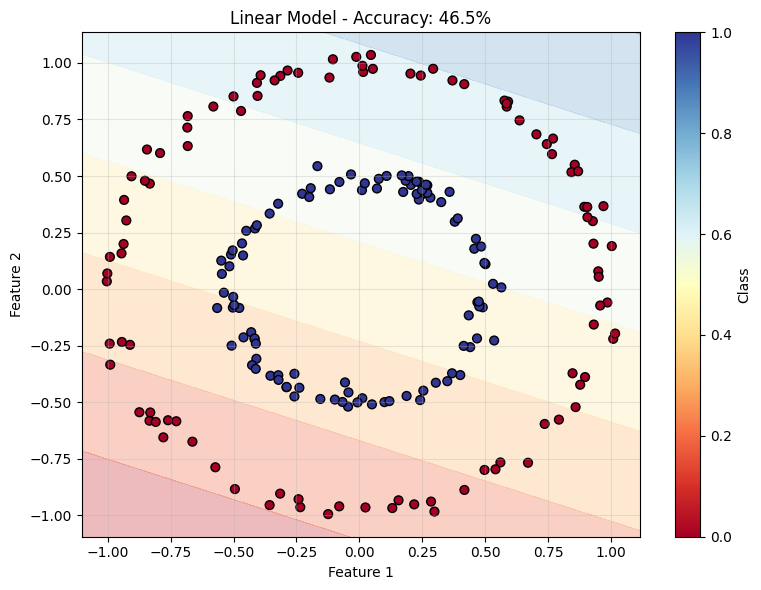

  - What does the non-linear model's boundary look like?


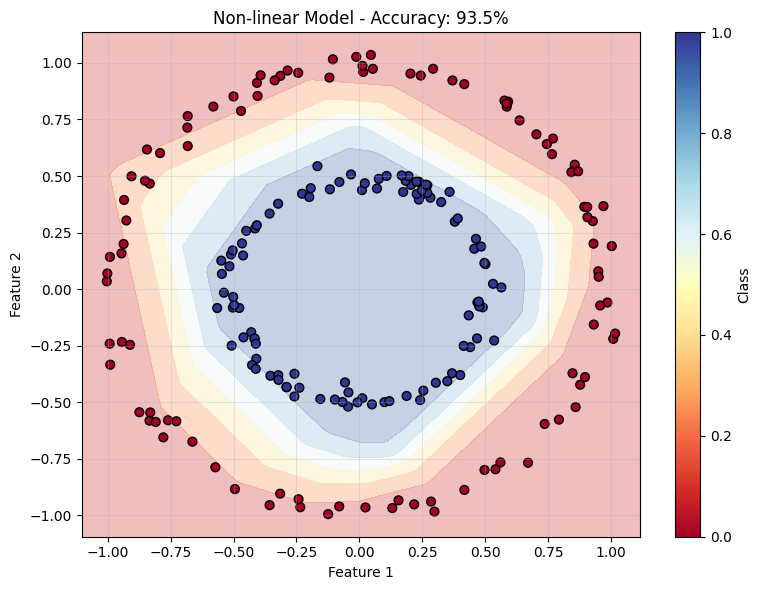

  - Why can't a straight line separate the circles?

Answer:
A straight line cannot separate the circles because this is a
NON-LINEARLY SEPARABLE problem. The data forms concentric circles
where one class is in the center and another surrounds it.

Key insights:
  1. Linear model: Can only create straight decision boundaries
     - Limited to equations like: w1*x + w2*y + b = 0
     - Cannot curve or bend to wrap around the inner circle
     - Poor accuracy on circular data

  2. Non-linear model: Creates curved decision boundaries
     - Uses activation functions (ReLU, Tanh) to learn curves
     - Can approximate circular/complex shapes
     - Much better accuracy on this dataset

  3. This demonstrates why deep learning is powerful:
     - Real-world problems are often non-linearly separable
     - Hidden layers + activations = ability to learn complex patterns

Tip: Visualize, visualize, visualize!


In [60]:
# Exercise 5: Compare decision boundaries
print("\nExercise 5: Compare decision boundaries")
print("Questions to answer:")

# Plot decision boundaries
X_test_np = X_test.cpu().numpy()
y_test_np = y_test.cpu().numpy().squeeze()

print("  - What does the linear model's boundary look like?")
plot_decision_boundary(model_v0, X_test_np, y_test_np,
                      f'Linear Model - Accuracy: {acc_v0*100:.1f}%')

print("  - What does the non-linear model's boundary look like?")
plot_decision_boundary(model_v1, X_test_np, y_test_np,
                      f'Non-linear Model - Accuracy: {acc_v1*100:.1f}%')

print("  - Why can't a straight line separate the circles?")

# Answer here
print("\nAnswer:")
print("A straight line cannot separate the circles because this is a")
print("NON-LINEARLY SEPARABLE problem. The data forms concentric circles")
print("where one class is in the center and another surrounds it.")
print("\nKey insights:")
print("  1. Linear model: Can only create straight decision boundaries")
print("     - Limited to equations like: w1*x + w2*y + b = 0")
print("     - Cannot curve or bend to wrap around the inner circle")
print("     - Poor accuracy on circular data")
print("\n  2. Non-linear model: Creates curved decision boundaries")
print("     - Uses activation functions (ReLU, Tanh) to learn curves")
print("     - Can approximate circular/complex shapes")
print("     - Much better accuracy on this dataset")
print("\n  3. This demonstrates why deep learning is powerful:")
print("     - Real-world problems are often non-linearly separable")
print("     - Hidden layers + activations = ability to learn complex patterns")

print("\nTip: Visualize, visualize, visualize!")